In [12]:
# IMPORTS
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
import nibabel as nib
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans, DBSCAN

Ici, nous traitons les dicoms relatifs à un cancer du pancréas et nous les transformons en numpy arrays. Nous pouvons remarqué que nous traitons des images de taille 260x320 encodée avec 345 valeurs.

In [2]:
ds = pydicom.read_file("data/IM-0001-0001-0001.dcm")
arr = ds.pixel_array

Pour la semaine S5, nous avons décidé de faire du traitement d'image en condisérant les histogrammes relatifs à ces images. Pour ce faire, nous avons implémenté différentes fonctions:    
    *  histogram(arr): retourne l'histogramme d'une image  
    *  Transformation(image, transform): retourne un nouvel array où la valeur des pixels a été transformée  
    *  crimping(arr): retourne un nouvel array dont les valeurs des pixels sont encodées sur 8 bits  
    *  equalize(arr): retourne un nouvel array dont l'histogramme est égalisé  
    *  cumulative(arr): retourne l'histogramme cumulé d'une image  
Toutes les fonctions semblent être en O(n^2)

In [3]:
# Plot histogram of the image above
def histogram(arr):
    maxValue = np.max(arr)
    h,w = arr.shape
    n = h*w
    histogram = np.array([0]*(maxValue+1))
    for i in arr:
        for j in i:
            histogram[j] += 1
    histogram_n = histogram/n#histogramme normalisé --> plus visible
    return histogram_n

def Transformation(image, transform):
    # This function is transforming an image with the Transform vector
    newArr = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[i])):
            newArr[i, j] = transform[image[i, j]]
    return newArr  

# Transformation or crimping procedure
def crimping(arr):
    maxValue = np.max(arr)
    histo = histogram(arr)
    Transform = np.arange(0,  maxValue + 1) # This will be the transformation vector
    deltaA = (maxValue - np.min(np.where(histo > 0)))/(255)
    Transform = np.ceil(Transform / deltaA)   
    # Apply the transformation to the original image
    newArr = Transformation(arr, Transform)
    return newArr
    # Plot final figure
    plt.imshow(newArr, cmap='Greys')
    # Plot des histogrammes
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot()

#Egalisation des histogrammes
def equalize(arr):
    h,w = arr.shape
    n = h*w
    C = ((344-1)/n)
    new_arr = np.zeros((h,w),dtype=int)
    histo = histogram(arr)*n
    for i in range(h):
        for j in range(w):
            value = arr[i,j]
            new_arr[i,j] = C*(np.sum(histo[0:value+1]))
    return new_arr

#Histogramme cumulé
def cumulative(arr):
    maxValue = np.max(arr)
    cumul = np.zeros((maxValue))
    histo = histogram(arr)
    for i in range(len(cumul)):
        cumul[i] = np.sum(histo[0:i+1])
    return cumul

Ici, nous appliquons nos différentes fonctions sur les images. Successivement, nous appliquons d'abord la méthode de crimping et ensuite celle qui égalise les histogrammes. Finalement, on calcule l'histogramme cumulé.

Text(0.5, 1.0, "Histogramme cumulé de l'image après égalisation")

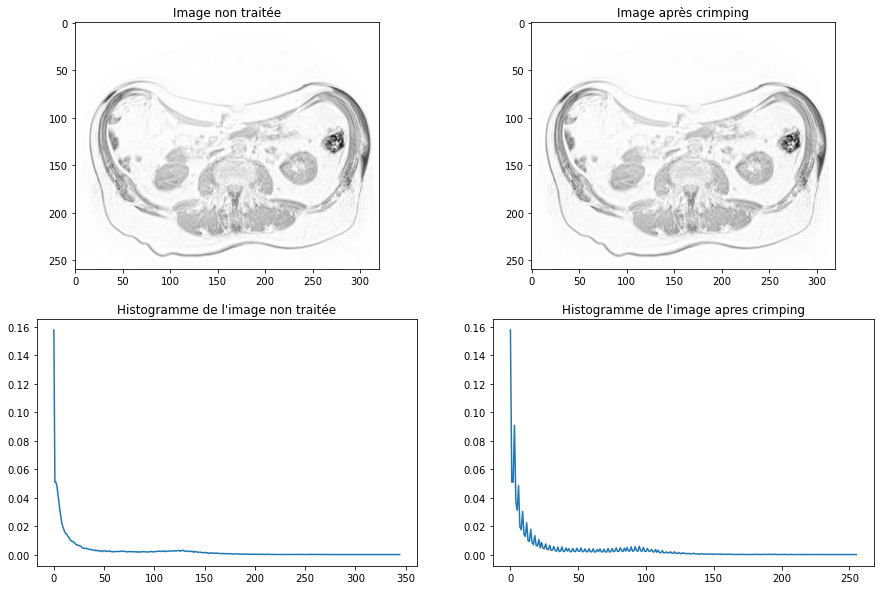

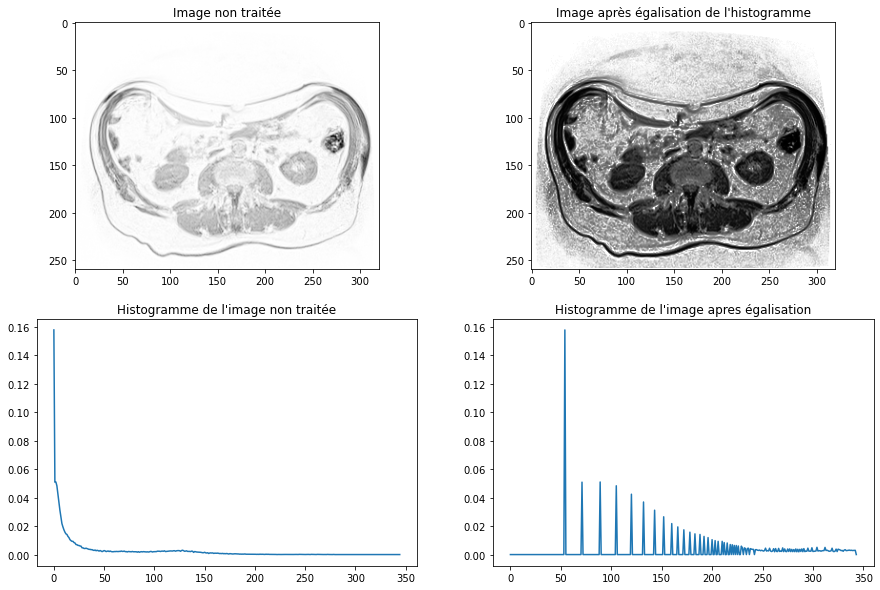

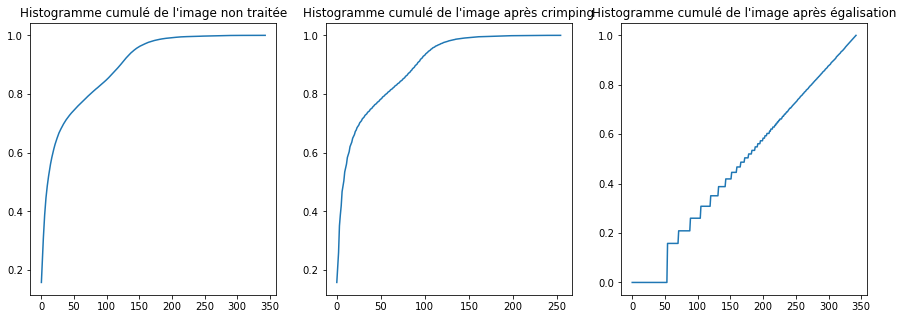

In [5]:
#calcul des variables utiles
arr_crimp = crimping(arr)
histo = histogram(arr)#histogramme de l image non traitee
histogram_lin = histogram(arr_crimp)#histogramme de l image apres crimping

arr_egal = equalize(arr)
histogram_egal = histogram(arr_egal)#histogramme de l image apres égalisation

cumul = cumulative(arr)
cumul_lin = cumulative(arr_crimp)
cumul_egal = cumulative(arr_egal)

#plot des figures relatives au crimping
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_crimp,cmap='Greys')
plt.title('Image après crimping')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_lin)
plt.title('Histogramme de l\'image apres crimping')

#plot des figures relatives à l'égalisation des histogrammes
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_egal,cmap='Greys')
plt.title('Image après égalisation de l\'histogramme')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_egal)
plt.title('Histogramme de l\'image apres égalisation')

#plot des figures relatives aux histogrammes cumulés
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(cumul)
plt.title('Histogramme cumulé de l\'image non traitée')
          
plt.subplot(1,3,2)
plt.plot(cumul_lin)
plt.title('Histogramme cumulé de l\'image après crimping')

plt.subplot(1,3,3)
plt.plot(cumul_egal)
plt.title('Histogramme cumulé de l\'image après égalisation')

Nous pouvons constater que l'application de la méthode crimping ne sert pas à grand chose. 
    C'est peut-être dû au fait que python représente l'image sur 8 bits de toute façon.
Nous pouvons constater que la méthode d'égalisation de l'histogramme fonctionne puisque l'histogramme cumulé tend vers une droite ! On voit que l'on met en évidence les détails mais aussi le bruit.
    On pourrait appliquer un filtrage du type hard thresholding pour supprimer le bruit.  
  
Suite à la réunion de S5, nous avons entendu parler de l'algorithme CLAHE. Celui-ci a été présenté par un autre groupe et donnait de meilleurs résultats qu'une simple égalisation des histogrammes. En effet, cet algorithme consiste à appliquer une égalisation d'histogramme sur des blocs de pixels de taille 8x8 (en général). Il permet donc de ne pas amplifier le bruit. Il nous semblait donc assez prometteur ! Nous avons essayé de l'implémenter nous-mêmes, comme le montre la fonction "Clahe". Cependant, notre algorithme n'est pas du tout optimisé et prend beaucoup de temps supplémentaire par rapport à un algorithme "tout fait" de python. Dès lors, nous avons décidé de continuer à utiliser cet algorithme mais pas comme une boîte noire puisque nous savons ce qu'il réalise. 

In [74]:
#Notre implémentation de CLAHE
def Clahe(arr):
    h,w = arr.shape
    new_arr = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            C = arr[i:i+7,j:j+7]
            new_C = equalize(C)
            new_arr[i:i+7,j:j+7] = new_C
            if (j+7 >= w):
                break
            else:
                j = j+7
        if(i+7>=h):
            break
        else:
            i = i+7
    plt.imshow(new_arr, cmap='Greys')

#Implémentation de python
def clahe(arr):
    clahe = cv2.createCLAHE()
    cl1 = clahe.apply(arr)
    return cl1

#L'implémentation de K-means
def kmeans(X,K,initype = 'random', maxIter = 100,plotIterations = True):
    """Some example here for good practice"""
    (N,dim) = X.shape
    # Initialization
    
    """ Switch intialization. Don't forget to reset N,X and K by running the upper cell """
    if (initype=='random'):
        centroids = np.random.random((K,dim)) # Random init
    elif (initype=='kmeans_pp'):
        centroids = kmeans_pp_init(X,K) 
    assignments = np.zeros(N)
    iterate = 0
    
    # TO COMPLETE
    convergence = False #pour stopper la boucle, on va regarder si on a convergé ou non
    if plotIterations: #pour le plot a iterate = 0
        plotTheCentroids(X,assignments,centroids,iterate)
    while((iterate <= maxIter) and (convergence == False)):#tant qu'on ne converge pas, on boucle
        iterate +=1   
        # step 1
        for i in range(N):
            distances = np.linalg.norm(centroids-X[i],axis=1)
            assignments[i] = np.argmin(distances)

        previousCentroids = np.copy(centroids)#permet de regarder la convergence des centroides
        # step 2
        for i in range(K):
            cluster = X[assignments == i]
            centroids[i] = np.mean(cluster,axis=0)
        convergence = np.array_equal(previousCentroids,centroids) #on regarde la convergence des centroides pour stopper plus tot
        if plotIterations:
            plotTheCentroids(X,assignments,centroids,iterate)        
            
    return centroids,assignments

#L'implémentation de K-means++
def kmeans_pp_init(X,K):
    def distance(u,A,j,N):
        D = np.zeros(N)

        for i in range(N):
            distance = u[i] - A[:j]
            D[i] = min(np.linalg.norm(distance, axis = -1))
        return D
    (N,dim) = X.shape
    # Initialization
    centroids = np.zeros((K,dim)) # TO BE MODIFIED
    centroids[0] = X[np.random.randint(0,N)]
    for k in range(1,K):
        D = distance(X,centroids,k,N)
        c = 1/sum(D**2)
        proba = c*(D**2)
        centroids[k] = X[np.random.choice(N,p=proba)]
            
    return centroids


Text(0.5, 1.0, 'Histogramme de l image traitée avec CLAHE')

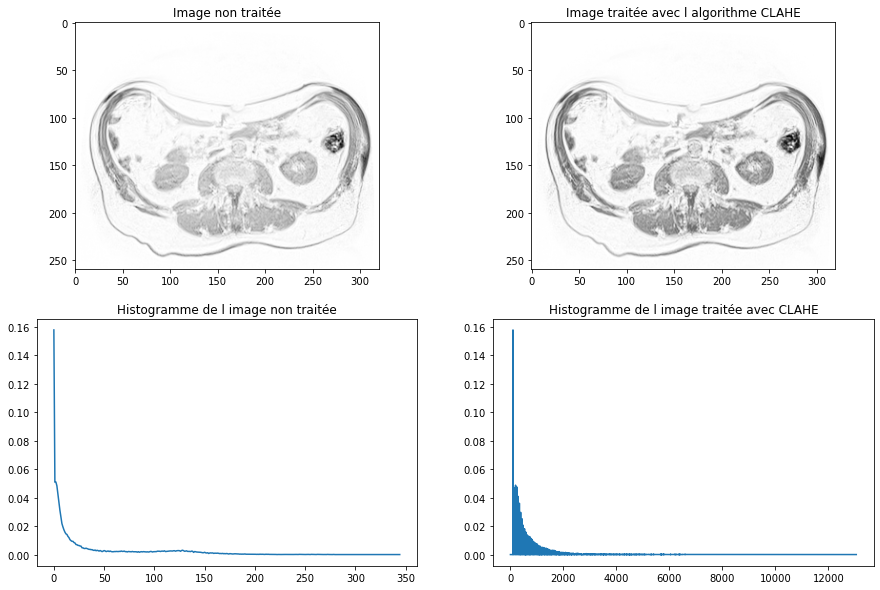

In [7]:
#Plot des résultats avec l'algorithme CLAHE
cl1 = clahe(arr)
histo = histogram(arr)#histogramme de l image non traitee
histo_cl1 = histogram(cl1)#histogramme après CLAHE

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(cl1, cmap='Greys')
plt.title('Image traitée avec l algorithme CLAHE')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l image non traitée')

plt.subplot(2,2,4)
plt.plot(histo_cl1)
plt.title('Histogramme de l image traitée avec CLAHE')

(320, 260, 112)


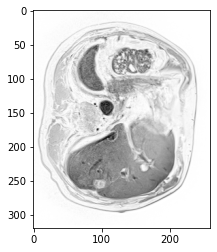

In [5]:
img = nib.load('Anonymized - L16223A_port__t1_vibe_dixon_tra_caipi4_bh_320_20161207155610_18.nii')
data = img.get_fdata()#pour avoir un numpy array
print(data.shape) #(320*260*112)
plt.imshow(data[:,:,50], cmap = 'Greys')#plot de la slice 50

In [32]:
#K-means
def NewListing3D(inputImage, layerDown, layerUP):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1]*inputImage.shape[2], 4))
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
            for k in range(layerDown, layerUP):
                X[k + inputImage.shape[2]*(j + inputImage.shape[1]*i), 0] = i
                X[k + inputImage.shape[2]*(j + inputImage.shape[1]*i), 1] = j
                X[k + inputImage.shape[2]*(j + inputImage.shape[1]*i), 2] = k
                X[k + inputImage.shape[2]*(j + inputImage.shape[1]*i), 3] = inputImage[i, j, k]
    return X

def NewListing3Dwo(inputImage, layerDown, layerUP):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1]*inputImage.shape[2], 1))
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
            for k in range(layerDown, layerUP):
                X[k + inputImage.shape[2]*(j + inputImage.shape[1]*i), 0] = inputImage[i, j, k]
    return X

def NewListing2D(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 3))
    for i in range(inputImage.shape[0]):
        for j in range(data.shape[1]):
                X[j + inputImage.shape[1]*i, 0] = i
                X[j + inputImage.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 2] = inputImage[i, j, layer]
    return X

def NewListing2D2D(inputImage):
    #Function will return a list of X, Y, Z, grayscale number
    X = []
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
            if inputImage[i, j] == 1:
                X.append([i, j])
                #X[j + inputImage.shape[1]*i, 1] = j*inputImage[i, j]
                #X[j + inputImage.shape[1]*i, 2] = inputImage[i, j]*3000
    #X = np.zeros((len(tmp), 2))
    #for i in range(len(X)):
    #    X[i, 0] = tmp[i][0]
    #    X[i, 1] = tmp[i][1]
        
    return np.array(X)

def NewListing2Dwo(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 1))
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
                #X[j + data.shape[1]*i, 0] = i
                #X[j + data.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 0] = inputImage[i, j, layer]
    return X
newData = NewListing2Dwo(data, 42)
newData3D = NewListing3Dwo(data, 37, 48)

In [75]:
K = 50
(c,assignments) = kmeans(NewListing2D(data, 42), K, 'kmeans_pp', 100, False)

In [76]:
imageOut = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut[i, j] = assignments[j + data.shape[1]*i]


Text(0.5, 1.0, 'Our k-means with 50 clusters (x, y, grayscale)')

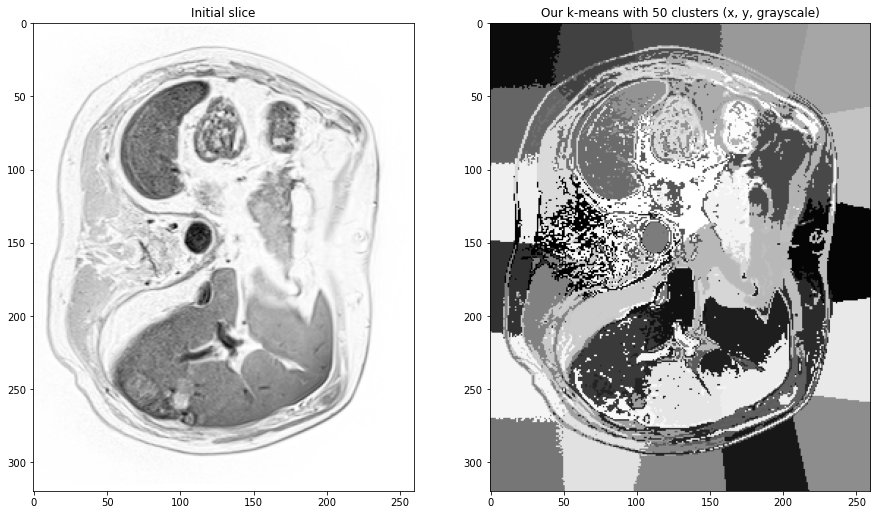

In [88]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, 42], cmap='Greys')
plt.title("Initial slice")
plt.subplot(1, 2, 2)
plt.imshow(imageOut, cmap='Greys')
plt.title("Our k-means with 50 clusters (x, y, grayscale)")

En S6-S7, nous avons implémenté du spectral clustering à l'aide des méthodes fournies dans la librairie python sklearn.

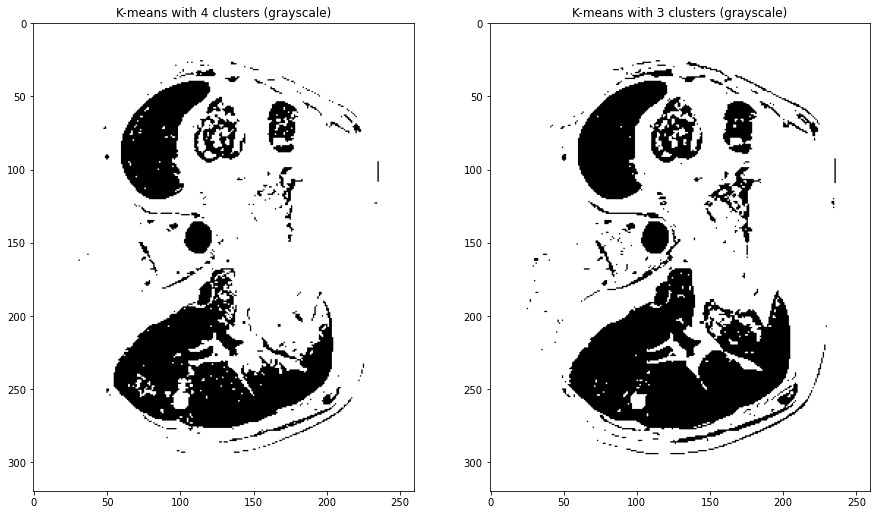

In [87]:
x = newData#data par slice
newData2 = NewListing2D(data, 42)
kmeans1 = KMeans(n_clusters=4).fit(x)
kmeans2 = KMeans(n_clusters=3).fit(x)
y_kmeans = kmeans1.predict(x)
y_kmeans2 = kmeans2.predict(x)
good_kernel = y_kmeans[100*300+ 250] # TO BE ADAPTED MAYBE
good_kernel2 = y_kmeans2[100*300+ 250] # TO BE ADAPTED MAYBE
y_bw = (y_kmeans == good_kernel)
y_bw2 = (y_kmeans2 == good_kernel2)
imageOut2 = np.zeros((data.shape[0], data.shape[1]))
imageOut22 = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut2[i, j] = y_bw[j + data.shape[1]*i]
        imageOut22[i, j] = y_bw2[j + data.shape[1]*i]

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(imageOut2, cmap='Greys')
plt.title("K-means with 4 clusters (grayscale)")
plt.subplot(1, 2, 2)
plt.imshow(imageOut22, cmap='Greys')
plt.title("K-means with 3 clusters (grayscale)")
plt.show()
#plt.imshow(imageOut22 - imageOut2, cmap='Greys')
#plt.show()

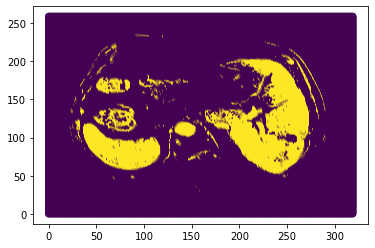

In [28]:
# plot
plt.scatter(newData2[:, 0], newData2[:, 1], c=y_bw) #TO BE ADAPTED
plt.show()

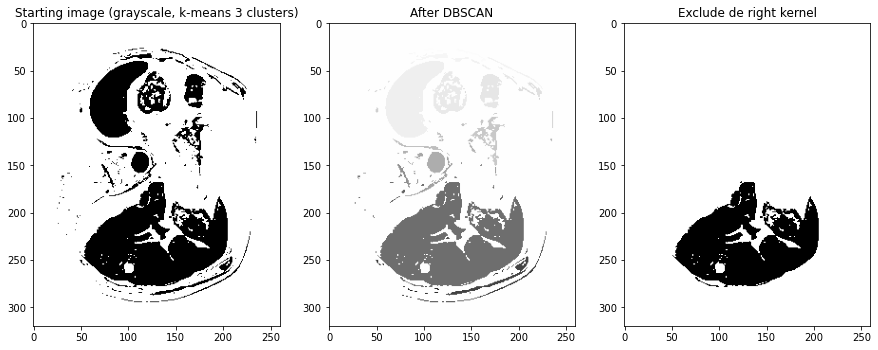

In [86]:
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(imageOut22, cmap='Greys')
plt.title("Starting image (grayscale, k-means 3 clusters)")
newData2 = NewListing2D2D(imageOut22)
X = newData2
clustering = DBSCAN(eps=1.5, min_samples=2).fit(X)
y = clustering.labels_
#print(y)

imageOut3 = np.zeros((imageOut22.shape[0], imageOut22.shape[1]))
for i in range(len(y)):
    #print(newData2[i, 0])
    imageOut3[newData2[i, 0], newData2[i, 1]] = y[i]
    
plt.subplot(1, 3, 2)
plt.imshow(imageOut3, cmap='Greys')
plt.title("After DBSCAN")
good_kernel_DBSCAN = y[9000] # TO BE ADAPTED MAYBE
plt.subplot(1, 3, 3)
plt.imshow((imageOut3 == good_kernel_DBSCAN), cmap='Greys')
plt.title("Exclude de right kernel")
plt.show()

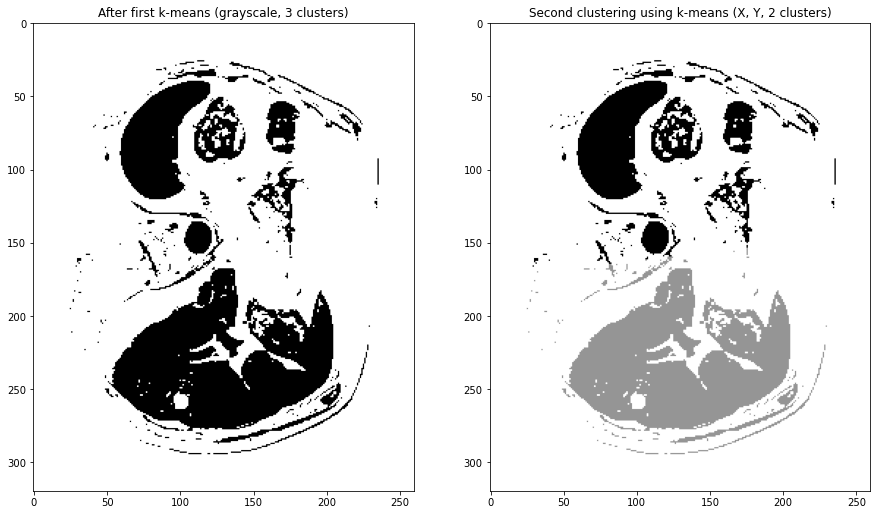

In [85]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(imageOut22, cmap='Greys')
plt.title("After first k-means (grayscale, 3 clusters)")
newData2 = NewListing2D2D(imageOut22)
kmeans = KMeans(n_clusters=2).fit(newData2)
y_kmeans = kmeans.predict(newData2)


imageOut3 = np.zeros((imageOut22.shape[0], imageOut22.shape[1]))
for i in range(len(newData2)):
    imageOut3[newData2[i, 0], newData2[i, 1]] = y_kmeans[i]+1
plt.subplot(1, 2, 2)
plt.imshow(imageOut3, cmap='Greys')
plt.title("Second clustering using k-means (X, Y, 2 clusters)")
plt.show()


In [126]:
#K-means in 3D marche pas :(
x = newData3D
kmeans = KMeans(n_clusters=4).fit(x)
y_kmeans = kmeans.predict(x)
good_kernel = y_kmeans[100*300+ 250] # TO BE ADAPTED MAYBE
y_bw = (y_kmeans == good_kernel)


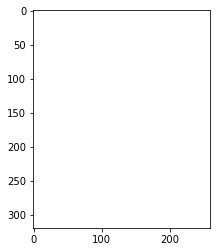

In [127]:
#imageOut3x = []
#imageOut3y = []
#imageOut3z = []
imageOut3 = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut3[i, j] = y_bw[1 + data.shape[2]*(j + data.shape[1]*i)]
#for i in range(data.shape[0]):
#    for j in range(data.shape[1]):
#        for k in range(12):
 #           #print(y_bw[k + data.shape[2]*(j + data.shape[1]*i)])
 #           if y_bw[k + data.shape[2]*(j + data.shape[1]*i)] == 1:
  #              imageOut3x.append(i)
  #              imageOut3y.append(j)
  #              imageOut3z.append(k)
#ax = plt.axes(projection='3d')
#ax.scatter3D(imageOut3x, imageOut3y, imageOut3z)
plt.imshow(imageOut3, cmap='Greys')
plt.show()